# A3

## Notes
My original dataset comprises 1000 gifs. I did not realize it would result in 701Mb of gifs and 2Gb of openface data. For this reason, the submitted dataset only comprises those gifs that OpenFace successfully processed. Among the OpenFace output, only the CSVs are preserved.

## Packages
### Used Packages 
* [tslearn](https://tslearn.readthedocs.io/en/stable/quickstart.html)
* Numpy
* Pandas
* SKlearn

## References
* [OpenFace 2.0](https://github.com/TadasBaltrusaitis/OpenFace/wiki): Facial Behavior Analysis Toolkit Tadas Baltrušaitis, Amir Zadeh, Yao Chong Lim, and Louis-Philippe Morency, IEEE International Conference on Automatic Face and Gesture Recognition, 2018
* Cassisi, C., Montalto, P., Aliotta, M., Cannata, A., & Pulvirenti, A. (2012). _Similarity measures and dimensionality reduction techniques for time series data mining_. Advances in data mining knowledge discovery and applications, 71-96.
* McKinney, W. (2012). _Python for data analysis: Data wrangling with Pandas, NumPy, and IPython_. " O'Reilly Media, Inc.".
* Shokoohi-Yekta, M., Hu, B., Jin, H., Wang, J., & Keogh, E. _Generalizing Dynamic Time Warping to the Multi-Dimensional Case Requires an Adaptive Approach (SDM 2015)_. In 2015 SIAM International Conference on Data Mining.-http://www. cs. ucr. edu/~ eamonn/Multi-Dimensional_DTW_Journal. pdf (last access: 18.12. 2015).
* [TsLearn](https://tslearn.readthedocs.io/en/stable/gettingstarted.html) documentation


In [55]:
%ls

A3.ipynb                 GIFGIF_Download.ipynb    requirements.txt
CreateDataset.ipynb      SubmissionPrep.ipynb     run_openface.py
GIFGIF_Dataset/          backup/                  utilities/
GIFGIF_Dataset_original/ media/                   venv/


## Imports

In [56]:
import pandas
import numpy
import glob
from typing import *
import umap

from sklearn import preprocessing

import tslearn.utils as tsutils
from tslearn.metrics import dtw
from tslearn.clustering import TimeSeriesKMeans, silhouette_score

import matplotlib.pyplot as plt

# Part 1

## Regenerate all data
set `REGENERATE` to true if you want to regenerate all data. If set to false, data saved to disk will be used. Regenerating all the data may be time-consuming, so be warned.

In [57]:
# Can take up to 1 hour
REGENERATE_DATASET = False

# Can take up to 3 hours
REGENERATE_BIC = False

## Dataset creation

As I am going through my semester working through 4 higher-division classes and 20 hours of part-time work per week, my emotions have shifted from peace to a combination of sadness, anger and powerlessness. In order to keep my attitude positive, I chose the better of the three: sadness. 

I downloaded 1000 gifs of sadness from OpenFace.

I was looking to run OpenFace on the gifs, but that is apparently not possible. After spending enough hours trying to install OpenFace on my machine through 3 different methods given in the Wiki (native MacOS, `bamos/openface` docker image, `algebr/openface` docker image and creating my own docker version), I decided to go with the existing docker image from `algebr/openface`, using the method [described here](https://github.com/TadasBaltrusaitis/OpenFace/wiki). I had issues with all of the other methods.

I converted all gifs to images, copied them to the docker container and and ran OpenFace on the sequences of images.
```bash=
docker run -it -d --rm algebr/openface:latest
docker cp images 3a73fbce562e:/home/openface-build
docker exec -it 3a73fbce562e sh
docker cp run_openface.py 3a73fbce562e:/home/openface-build
```
I then ran the `run_openface.py` script to create the CSVs out of the image folders:

```python=
import glob
import subprocess
import os

directories = glob.glob("images/*")
output = "output"

for dir in directories:
    output_dir = "%s/%s" % (output, dir)
    os.makedirs(output_dir)
    process = subprocess.Popen(["build/bin/FeatureExtraction", "-fdir", dir, "-out_dir", output_dir])
    process.wait()
```

and copied the results to my local machine:
```bash
docker cp  40b27:/home/openface-build/output ./output
```

My first look at the processed data seem to imply that OpenFace failed to parse all of the cartoons. It did show partial information, but instances of cartoons may need to be dropped from the dataset. Only images of real humans were fully labelled.

_NOTE: not sure how to submite my assignment with my dataset as it is 2GB_

## Approach

I am not certain how to approach a multivariate DTW problem. It seems like there are two main approaches [(2015, Shokoohi-Yekta et al)](https://link.springer.com/article/10.1007/s10618-016-0455-0):
1. Independent DTW: find the distance between every dimension for two time series. For multi-dimensional time series (MDT) Q and C, $$DTW_1(Q, C) = \sum_{m=1}^{M} DTW(Q_m, C_m)$$ Each dimension is independent.
2. Dependent DTW: warp all dimensions in a single warping matrix. The dimensions are now dependent. It's similar to single-dimension DTW, except the distance is measured for M data-points. The following distance function is used: $$d(q_i, c_j) = \sum_{m=1}^{M} DTW(q_{i, m}, c_{j, m})^2$$

### Areas of interest in the data
[See here for in-depth explanations about output format of OpenFace](https://github.com/TadasBaltrusaitis/OpenFace/wiki/Output-Format)

[OpenFace action units information](https://github.com/TadasBaltrusaitis/OpenFace/wiki/Action-Units)

#### All columns in the CSVs



| Column                         | Description                                                  | Notes                                                        | Selected |
| ------------------------------ | ------------------------------------------------------------ | ------------------------------------------------------------ | -------- |
| `gaze_0_x, gaze_0_y, gaze_0_z` | eye 0, leftmost eye in image                                 |                                                              | N        |
| `gaze_1_x, gaze_1_y, gaze_1_z` | Eye 1, rightmost eye in image                                |                                                              | N        |
| `gaze_angle_x, gaze_angle_y`   | Eye gaze direction in radians in world coordinates averaged for both eyes and converted into more easy to use format than gaze vectors | Might want to use that over `gaze`, as `gaze` is containted in it. | Y        |
| `eye_lmk_x*, eye_lmk_X*`       | location of 3D eye in pixels (x) and mm (X)                  | Redundant if using head rotation and translation             | N        |
| `pose_Rx, pose_Ry, pose_Rz`    | pitch, yaw and roll for head in radians in relation to camera | Head rotation may be useful                                  | Y        |
| `pose_Tx, pose_Ty, pose_Tz`    | location of the head with respect to camera in millimeters   | Head translation may be useful                               | Y        |
| `AU_r`                         | Action units intesity of 17 AUs (from 0 to 5)                | Definitely useful                                            | Y        |
| `AU_c`                         | Action unit presence of 18 AUs                               | Definitely useful                                            | Y        |

#### Fourier Transform
Should I apply a Fourier transform on the time series, and run DTW on the output, or should I simply run DTW on the current time series?

#### Number of features
The model may overfit if too many features are provided. Try at least 3 different amount of features.

## Infrastructure

### Preprocess time series 
* Normalize to have zero mean and unit variance
* [Resample?](https://tslearn.readthedocs.io/en/stable/gen_modules/preprocessing/tslearn.preprocessing.TimeSeriesResampler.html#tslearn.preprocessing.TimeSeriesResampler)

Apply UMAP to related dimensions to decrease number of dimensions.

In [58]:
# Make UMAP reproducible by using the same reducer with a set random state
reducer = umap.UMAP(random_state=42, n_components=2)

def apply_umap(pd: List[List]):
    """Return a table with less columns by reducing dimensions"""
    # Apply UMAP
    # print(pd.head())
    reducer.fit(pd)
    embedding = reducer.transform(pd)
    print(f"New embedding column number: {len(embedding[0, :])}")
    return pandas.DataFrame.from_records(embedding)

def preprocess(df, AU_only) -> List[Any]:
    """
    * Normalize to have zero mean and unit variance for every dimension.
    * Select wanted dimensions.
    """
    if AU_only:
        df = df[[
                    "AU01_r",
                    "AU02_r",
                    "AU04_r",
                    "AU05_r",
                    "AU06_r",
                    "AU07_r",
                    "AU09_r",
                    "AU10_r",
                    "AU12_r",
                    "AU14_r",
                    "AU15_r",
                    "AU17_r",
                    "AU20_r",
                    "AU23_r",
                    "AU25_r",
                    "AU26_r",
                    "AU45_r",
                    "AU28_c" # This one not contained in AU*_r
        ]].copy()
    else:
        df = df[[
                    "gaze_angle_x",
                    "gaze_angle_y",
                    "pose_Rx",
                    "pose_Ry",
                    "pose_Rz",
                    "pose_Tx",
                    "pose_Ty",
                    "pose_Tz",
                    "AU01_r",
                    "AU02_r",
                    "AU04_r",
                    "AU05_r",
                    "AU06_r",
                    "AU07_r",
                    "AU09_r",
                    "AU10_r",
                    "AU12_r",
                    "AU14_r",
                    "AU15_r",
                    "AU17_r",
                    "AU20_r",
                    "AU23_r",
                    "AU25_r",
                    "AU26_r",
                    "AU45_r",
                    "AU28_c" # This one not contained in AU*_r
        ]].copy()
    
    df = pandas.DataFrame(preprocessing.scale(df), columns=df.columns)
    
    # Let's apply UMAP to the whole time series at once
    df_new = apply_umap(df)

    return df_new

In [59]:
def centroids_prototype(centroids, X):
    """Return one or more prototype for each centroid"""
    prototypes = {i: {"dist": float("inf"), "index": 0} for i in range(len(centroids))}

    for i, _ in enumerate(centroids):
        for j, _ in enumerate(X):
            dist = dtw(centroids[i], X[j])
            if dist < prototypes[i]["dist"]:
                prototypes[i] = {"dist": dist, "index": j}
    return prototypes

def centroids_prototypes(centroids, X, num_protos=4):
    """Return more than one prototype for each centroid"""
    if num_protos == 1:
        print("number of centroids must be greater than 1")
        return
    prototypes: List[Tuple(float, int)] = []

    for i, _ in enumerate(centroids):
        tmp = []
        for j, _ in enumerate(X):
            dist = dtw(centroids[i], X[j])
            tmp.append((dist, j))
        tmp.sort(key=lambda tup: tup[0])
        prototypes.append(tmp[:num_protos])
            
    return prototypes

### Create time series datasets

In [60]:
import json

CSV_EXT = ".csv"
TIME_SERIES_DATASETS_PATH = "GIFGIF_Dataset/time_series_datasets"

# Track which gifs and openface dir numbers are used for dataset
gifs_used = {}

def extract_time_series_dataset(path: str, AU_only=False) -> List[Any]:
    """Create a time series dataset from all CSVs located at in 
    a directory
    :param path: path of the directory
    """
    if path[-1] == "/":
        path = path[:-1]
    dirs = glob.glob(f"{path}/*")

    # Save every gif's openface dataset in a pandas dataframe.
    time_series_list = []
    
    backup_file_name = path.split("/")[-1]
    backup_file_path = f"{TIME_SERIES_DATASETS_PATH}/{backup_file_name}.txt"

    print(f"Creating dataset for {path}")

    # Keep track of number of created time series
    created_count = 0
    # time_series_labels show the path to the OpenFace dir
    time_series_labels = []

    for dir in dirs:
        filename = dir.split("/")[-1]
        csv_filepath = f"{dir}/{filename}{CSV_EXT}"
        with open(csv_filepath) as f:
            df = pandas.read_csv(f, dtype=float)

            # Column names sometimes have an extra space on the left or right
            df.rename(columns=lambda x: x.strip(), inplace=True)

            if df.loc[:, "confidence"].mean() < 0.8:
                continue
            
            # Save dirname to dict to make up list of all used gifs and openface data
            gifs_used[filename] = True
            
            # Remove all NA rows
            df.dropna()

            # Select only wanted columns and scale
            df_new = preprocess(df, AU_only)

            formatted_time_series = tsutils.to_time_series(df_new)
            time_series_list.append(formatted_time_series)
            time_series_labels.append(dir)
            created_count += 1

    with open('GIFGIF_Dataset/gifs.json', 'w') as fp:
        json.dump(gifs_used, fp)
    
    time_series_dataset = tsutils.to_time_series_dataset(time_series_list)

    print(f"Saving dataset for {path} to file {backup_file_path}")
    tsutils.save_time_series_txt(backup_file_path, time_series_dataset)
    print(f"Created {created_count} time series for time series dataset")
    return time_series_dataset, time_series_labels

## Load Dataset
Load the generated CSVs into a pandas dataframe.

In [61]:
%%time
%%capture
BACKUP = "backup"

OPENFACE_DATA = "GIFGIF_Dataset/openface"

X_file = f"{BACKUP}/X"
X_labels_file = f"{BACKUP}/X_labels"

X = None
X_labels = None

if REGENERATE_DATASET:
    X, X_labels = extract_time_series_dataset(f"{OPENFACE_DATA}/sadness/", AU_only=False)
    
    numpy.save(X_file, X)
    numpy.save(X_labels_file, X_labels)
else:
    # Read from file
    X = numpy.load(X_file + ".npy")
    X_labels = numpy.load(X_labels_file + ".npy")

CPU times: user 5.24 ms, sys: 3.36 ms, total: 8.61 ms
Wall time: 6.97 ms


In [62]:
%%time
%%capture

X_AU_only_file = f"{BACKUP}/X_AU_only"
X_AU_only_labels_file = f"{BACKUP}/X_AU_only_labels"

X_AU_only = None
X_AU_only_labels = None

if REGENERATE_DATASET:
    X_AU_only, X_AU_only_labels = extract_time_series_dataset(f"{OPENFACE_DATA}/sadness/", AU_only=True)
    numpy.save(X_AU_only_file, X_AU_only)
    numpy.save(X_AU_only_labels_file, X_AU_only_labels)
else:
    # Read from file
    X_AU_only = numpy.load(X_AU_only_file + ".npy")
    X_AU_only_labels = numpy.load(X_AU_only_labels_file + ".npy")

CPU times: user 3.48 ms, sys: 2.37 ms, total: 5.85 ms
Wall time: 6.18 ms


# Part 2

# Silhouette Coefficients
The higher the silhouette coefficient, the better the clustering. The silhouette coefficient [is defined as](https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient):
* a: The mean distance between a sample and all other points in the same class.
* b: The mean distance between a sample and all other points in the next nearest cluster.
The silhouette coefficient for a sample $s$ is given by: $$s = \frac{b-a}{max(a, b)}$$
The silhouette coefficient for a set is the mean of the silhouette coefficient of every member in that set.

More info on silhouette coefficients from [sklearn](https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient).

In [63]:
%%time
%%capture

num_clusters = numpy.arange(2, 14)

def calculate_BIC(X, labels):
    sil: List[float] = []
        
    for num_cluster in num_clusters:
        km = TimeSeriesKMeans(n_clusters=num_cluster, metric="dtw").fit(X)
        labels = km.labels_
        score = silhouette_score(X, labels, metric="dtw")
        sil.append(score)
    
    return sil, X, labels

CPU times: user 2.21 ms, sys: 134 µs, total: 2.34 ms
Wall time: 2.35 ms


In [64]:
MEDIA = "media"

def plt_BIC(sil, X, labels, name):
    plt.plot(num_clusters, sil)
    plt.title('Silhouette Scores')
    plt.ylabel('silhouette score')
    plt.xlabel('number of cluster')
    plt.grid(True)
    # Save plot
    plt.savefig(f"{MEDIA}/silhoutte_score_{name}.png")
    plt.show()


In [65]:
%%time
%%capture

if REGENERATE_BIC:
    sil, X_, labels = calculate_BIC(X, X_labels)
    plt_BIC(sil, X_, labels, "X")

CPU times: user 1.07 ms, sys: 27 µs, total: 1.09 ms
Wall time: 1.1 ms


Silhouette score for dataset with all columns:

<img src="media/silhoutte_score_X.png">

In [66]:
%%time
%%capture

if REGENERATE_BIC:
    sil, X_, labels = calculate_BIC(X_AU_only, X_AU_only_labels)
    plt_BIC(sil, X_, labels, "X_AU_only")

CPU times: user 1.55 ms, sys: 113 µs, total: 1.66 ms
Wall time: 1.75 ms


Silhouette score for dataset with only AU columns:

<img src="media/silhoutte_score_X_AU_only.png">

In [67]:
%%time
%%capture
km_all_3_clusters = TimeSeriesKMeans(n_clusters=3, metric="dtw").fit(X)

CPU times: user 1min 37s, sys: 617 ms, total: 1min 37s
Wall time: 1min 38s


In [68]:
%%time
%%capture
km_only_AU_6_clusters = TimeSeriesKMeans(n_clusters=6, metric="dtw").fit(X_AU_only)

CPU times: user 3min 24s, sys: 1.14 s, total: 3min 25s
Wall time: 3min 26s


## Prototype for each centroid
What I call prototype is the point closest to each centroid, it is the best representant of that centroid.

### Best for all categories
To change the number of prototypes shown for each cluster, adjust `NUM_PROTOTYPES`. **Note that it must be set to a value greater than 2**.

In [69]:
NUM_PROTOTYPES = 6

centroids_all_features = km_all_3_clusters.cluster_centers_
prototypes_all_features = centroids_prototype(centroids_all_features, X)
multiple_prototypes_all_features = centroids_prototypes(centroids_all_features, X, num_protos=NUM_PROTOTYPES)

In [70]:
print(multiple_prototypes_all_features)

[[(8.990399170665707, 391), (9.999294836880383, 342), (10.419463972265099, 154), (11.231390154403085, 52), (11.620424020296749, 235), (11.727160317144914, 469)], [(11.14725158217246, 311), (12.130908268891012, 155), (12.897133555790555, 88), (13.059793401959935, 363), (13.205390376067594, 38), (13.417468709200262, 36)], [(8.142240607354687, 128), (8.775517044312885, 336), (9.471681012572615, 472), (10.092722573111187, 20), (10.416875283869839, 118), (10.57009129280283, 5)]]


OpenFace was set to detect single faces only. Gifs that include more than one face only contain landmarks and action units for one face. An OpenFace `aligned image` (show who's face was processed) is provided to determine which person is being classified. There are sometimes multiple person in a gifs, but OpenFace was run in single face mode. According to the documentation, this setting makes OpenFace more accurate, which is why I chose to go with it.

In [71]:
# import matplotlib.image as mpimg
from IPython.display import Image, Video


GIFS_SADNESS = "GIFGIF_Dataset/gifs"

def prototype_images(prototypes):
    # Getting dict of single proto
    if type(prototypes[0]) == dict:
        for key, _ in enumerate(prototypes):
                print(f"distance: {prototypes[key]['dist']}")
                # Get OpenDace data path from prototype index
                openface_dir = X_labels[(prototypes[key]["index"])]
                gif_name = openface_dir.split("/")[-1]
                print(gif_name)

                gif_path = f"{GIFS_SADNESS}/{gif_name}.gif"

                with open(gif_path,'rb') as file:
                    display(Image(file.read()))
                print(f"{openface_dir}/{gif_name}.avi")
                with open(f"{openface_dir}/{gif_name}_aligned/frame_det_00_000001.jpg",'rb') as file:
                    display(Image(file.read()))
                    
    # Getting list of multiple protos
    else:
        for key, cluster in enumerate(prototypes):
            print("\n####################################################################")
            print(f"CLUSTER {key+1}")
            print("####################################################################")
            for example in cluster:
                
                print(f"distance: {example[0]}")
                # Get OpenDace data path from prototype index
                openface_dir = X_labels[example[1]]
                gif_name = openface_dir.split("/")[-1]
                gif_path = f"{GIFS_SADNESS}/{gif_name}.gif"

                with open(gif_path,'rb') as file:
                    display(Image(file.read()))
                print(f"{openface_dir}/{gif_name}.avi")
                with open(f"{openface_dir}/{gif_name}_aligned/frame_det_00_000001.bmp",'rb') as file:
                    display(Image(file.read()))
                
                

The best gifs for each categories are displayed below. 
Unfortunately, the whole notebook was re-run before submission and the dataset having non-deterministic aspects, turned out to be different. This invalidated my below observations. Looking at the gifs in each cluster, there are only minor variations.

The following are my observations for each cluster:
#### Cluster 1
* Generally disappointed. Michael Cera looks like he is disappointed of himself (perhaps shame). The second gif shows a man who after trying his best, failed. The third gifs of the woman turning her head away is hard to decipher. It could guilt. Woody Harrelson looks disappointed and sorry for himself. Simon Pegg displays the same emotions as the man in the second gif.
* The analyzed face seems to always be moving: small camera shake, turning head, head moving laterally
* Their mouths look to either be open or moving
#### Cluster 2
* Generally hopeless, grimacing, wincing
* The 8th best prototype shows one person (Conan O'Brien) and then another (Andy Richter). Checking the data shows that both were treated as a single time series. This introduces errors. I wonder if there are others like it. Ideally, I would remove these gifs from dataset.
* Adam Sandler and Frodo looks hopeless and devastated. Edward Norton looks hopeless, lifeless and motionless. Norton has a lot of shadow play over his face, I wonder if this impacted OpenFace's processins. Ryan Reynolds is hard to decipher. He is clearly acting out sadness and has a lot of facial movements. The women in the gif after Norton shows her first sad and then frowning. The character from Les miserables seems hopeless and devastated. Her face is extremelly dynamic. 
#### Cluster 3
* Generally grief, or a "what the hell" attitude
* Jennifer Lawrence looks quietly sad. In the movie she is paying tribute to a fallen comrade. I wonder how much her arm hiding parts of her face affects OpenFace at the beginning. The second gif show a little girl faking sadness. She is acting it out like Ryan Reynolds did in the second cluster, except that Reynolds is more forceful with the expression. The third gif shows a sad, perhaps grieving woman who also appear hopeful. She looks like she might almost smile. The next guys (gif 632) seems sad, annoyed and defeated. Kanye looks stunned, staring down the interviewer. In the last gif, captain Kirk seems sad and having lost his words.


####################################################################
CLUSTER 1
####################################################################
distance: 8.990399170665707


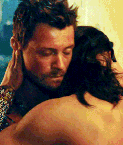

GIFGIF_Dataset/openface/sadness/296/296.avi


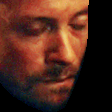

distance: 9.999294836880383


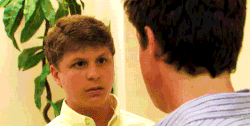

GIFGIF_Dataset/openface/sadness/849/849.avi


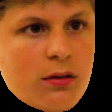

distance: 10.419463972265099


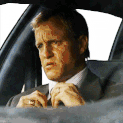

GIFGIF_Dataset/openface/sadness/256/256.avi


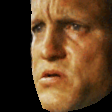

distance: 11.231390154403085


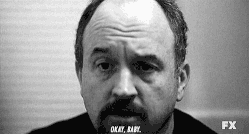

GIFGIF_Dataset/openface/sadness/990/990.avi


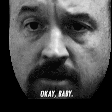

distance: 11.620424020296749


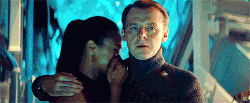

GIFGIF_Dataset/openface/sadness/322/322.avi


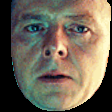

distance: 11.727160317144914


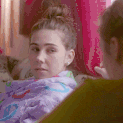

GIFGIF_Dataset/openface/sadness/584/584.avi


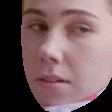


####################################################################
CLUSTER 2
####################################################################
distance: 11.14725158217246


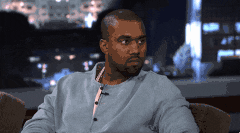

GIFGIF_Dataset/openface/sadness/841/841.avi


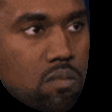

distance: 12.130908268891012


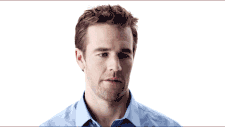

GIFGIF_Dataset/openface/sadness/632/632.avi


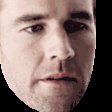

distance: 12.897133555790555


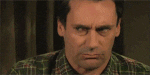

GIFGIF_Dataset/openface/sadness/242/242.avi


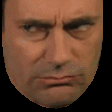

distance: 13.059793401959935


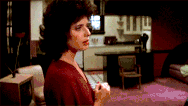

GIFGIF_Dataset/openface/sadness/646/646.avi


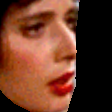

distance: 13.205390376067594


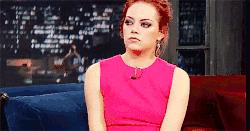

GIFGIF_Dataset/openface/sadness/765/765.avi


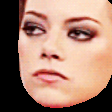

distance: 13.417468709200262


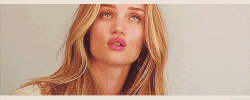

GIFGIF_Dataset/openface/sadness/798/798.avi


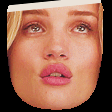


####################################################################
CLUSTER 3
####################################################################
distance: 8.142240607354687


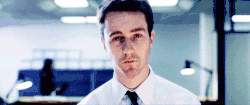

GIFGIF_Dataset/openface/sadness/261/261.avi


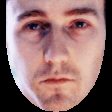

distance: 8.775517044312885


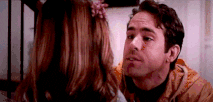

GIFGIF_Dataset/openface/sadness/812/812.avi


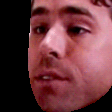

distance: 9.471681012572615


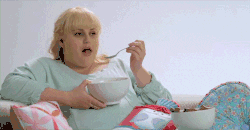

GIFGIF_Dataset/openface/sadness/910/910.avi


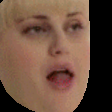

distance: 10.092722573111187


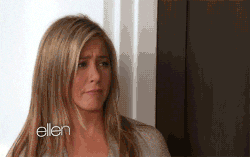

GIFGIF_Dataset/openface/sadness/701/701.avi


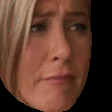

distance: 10.416875283869839


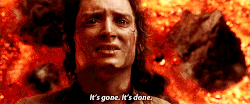

GIFGIF_Dataset/openface/sadness/401/401.avi


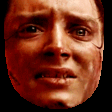

distance: 10.57009129280283


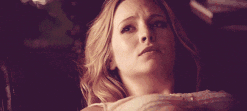

GIFGIF_Dataset/openface/sadness/66/66.avi


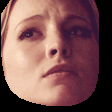

In [93]:
prototype_images(multiple_prototypes_all_features)

### 4 clusters

The code to visualize the gifs closest to each cluster is below this cell. I found it to be extremelly difficult to find any patterns in the 6 categories. There is no consistency. Interestingly, 2 gifs of Kanye win which he displays the same sadness appear in the same cluster, which tells me that the clustering is working on some level. 

Due to the lack of consistency in clusters for the AU only dataset, I decided not to continue with this model. The rest of this research assignment is based on the 3 clusters with `pose` and `gaze.

In [73]:
# centroids_only_AU = km_only_AU_6_clusters.cluster_centers_
# prototypes_only_AU = centroids_prototype(centroids_only_AU, X_AU_only)
# multiple_prototypes_only_AU = centroids_prototypes(centroids_only_AU, X_AU_only)
# 
# # prototype_images(prototypes_4)
# prototype_images(multiple_prototypes_only_AU)

# Part 3
Order the dataset in order of closest point to the chosen cluster (social signal). Create a dataset picking 15 points that are closest to this cluster, and 15 points that are fartherst from it.

Print out the 30 gifs to get an idea of the sets.

Create a 5-fold cross-validation set that is 80% training and 20% testing.
For each train a model and test it.

Average the performance to get KNN and multidimensional DTW performance on the dataset.

I selected cluster 1 from earlier as I thought it was the most distinctive one. `point_dist` selects the distance between cluster 1 and its best representant.

In [83]:
point_dist = multiple_prototypes_all_features[0][0][0]
print(point_dist)

8.990399170665707


The following function returns the distance to the cluster and the index of that point in the `X` training dataset.

In [84]:
# This is pretty ugly, but I did not have time to come up with a better way.
# This function orders the dataset from closest to further from a selected centroid.
# The manner this centroid is selected is UGLY. I am sorry about that.
# There is no way right now to get to the dataset index from a directory number (from the openface dataset).
# Therefore, the correct centroid is selected by the distance to its closest point. Again,
# I would try to make this better if I had the time, but I don't.
def get_best_and_worst(centroids, X, point_dist):
    """"Return the dataset sorted from closest to furthest from a centroid.
    :param point_dist: the point that is the closest to the wanted centroid. This is used 
    to identify an approximation to the center of a centroid, using previously calculated distances for
    best representant of cluster.
    """
    prototypes: List[Tuple(float, int)] = []

    for i, _ in enumerate(centroids):
        tmp = []
        for j, _ in enumerate(X):
            dist = dtw(centroids[i], X[j])
            tmp.append((dist, j))
        tmp.sort(key=lambda tup: tup[0])
        if tmp[0][0] == point_dist:
            return tmp
    return

X_Part_3 = get_best_and_worst(centroids_all_features, X, point_dist)
print(X_Part_3[:3])

[(8.990399170665707, 391), (9.999294836880383, 342), (10.419463972265099, 154)]


In [85]:
NUM_SAMPLES = 30

X_indices = []

for _, index in X_Part_3:
    X_indices.append(index)

closest = X_indices[:NUM_SAMPLES]
furthest = X_indices[-NUM_SAMPLES:]

X_indices = closest + furthest

# Point that have index [0,30) are positive (chosen class), [30,60) are negative (other class)
print(X_indices)

[391, 342, 154, 52, 235, 469, 111, 419, 417, 443, 302, 272, 210, 4, 409, 81, 181, 215, 34, 251, 332, 99, 494, 357, 214, 404, 112, 22, 143, 40, 15, 388, 265, 387, 360, 74, 72, 461, 31, 150, 64, 393, 51, 239, 323, 49, 147, 136, 334, 124, 55, 89, 123, 264, 410, 356, 325, 291, 365, 346]


In [86]:
new_X = numpy.copy(X[X_indices,])

positive_class = [1 for i in range(NUM_SAMPLES)]
negative_class = [0 for i in range(NUM_SAMPLES)]
new_Y = numpy.array(positive_class + negative_class)

In [88]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
kf.get_n_splits(new_X)

def cross_validation(X, y):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        _, y_test = y[train_index], y[test_index]
        
        km_all_features = TimeSeriesKMeans(n_clusters=2, metric="dtw", random_state=0).fit(X_train)
        result = km_all_features.predict(X_test)
        
        for i in range(len(result)):
            if result[i] == 1 and y_test[i] == 1:
                TP += 1
            if result[i] == 1 and y_test[i] == 0:
                FP += 1
            if result[i] == 0 and y_test[i] == 1:
                FN += 1
            if result[i] == 0 and y_test[i] == 0:
                TN += 1
            
        print(y_test)
        print(result)
        print()
    print(f"True Positive: {TP}")
    print(f"False Positive: {FP}")
    print(f"True Negative: {TN}")
    print(f"False Negative: {FN}")

cross_validation(new_X, new_Y)

[1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1]

[1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1]

[1 1 1 1 1 1 0 0 0 0 0 0]
[1 1 1 1 1 1 1 0 0 1 1 1]

[0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 1 0 0 0 0 0 0]

[0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 0 0 0 1 0 0 0 0]

True Positive: 30
False Positive: 8
True Negative: 22
False Negative: 0


## Conclusion
The most difficult aspect of this assignment was determining what social signals were shared among each cluster. While my trained models may be faulty somewhere unsuspected, The 6 cluster model does classify two different gifs of Kanye int the same cluster. Because they are depicting the same emotions, it seems natural. This tells me that the 6 cluster model is probably correct, as the same individual showing the same expression in two separate gifs should be classified in the same cluster.